Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/MachineLearningNotebooks/how-to-use-azureml/automated-machine-learning/remote-amlcompute/auto-ml-remote-amlcompute.png)

# Automated Machine Learning
_**Remote Execution using AmlCompute**_

## Contents
1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)
1. [Results](#Results)
1. [Test](#Test)

**This notebook showcase how to run aumoml on remote compute. There are 3 quiz in this notebook, finish the quiz to win T-shirt!**

## Introduction
In this example we use the scikit-learn's [digit dataset](http://scikit-learn.org/stable/datasets/index.html#optical-recognition-of-handwritten-digits-dataset) to showcase how you can use AutoML for a simple classification problem.

Make sure you have executed the [configuration](../../../configuration.ipynb) before running this notebook.

In this notebook you would see
1. Create an `Experiment` in an existing `Workspace`.
2. Create or Attach existing AmlCompute to a workspace.
3. Configure AutoML using `AutoMLConfig`.
4. Train the model using AmlCompute
5. Explore the results.
6. Test the best fitted model.

In addition this notebook showcases the following features
- **Parallel** executions for iterations
- **Asynchronous** tracking of progress
- **Cancellation** of individual iterations or the entire run
- Retrieving models for any iteration or logged metric
- Specifying AutoML settings as `**kwargs`

## Setup

As part of the setup you have already created an Azure ML `Workspace` object. For AutoML you will need to create an `Experiment` object, which is a named object in a `Workspace` used to run experiments.

In [36]:
import logging
import os
import csv

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig

In [37]:
ws = Workspace.from_config()

# Choose a name for the run history container in the workspace.
experiment_name = 'automl-remote-amlcompute'
project_folder = './project'

experiment = Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace Name'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
SDK version,1.0.33
Subscription ID,ee85ed72-2b26-48f6-a0e8-cb5bcf98fbd9
Workspace Name,zhanxiaAML
Resource Group,MT
Location,eastus
Project Directory,./project
Experiment Name,automl-remote-amlcompute


### ***Quiz 1 - whitelist models***
*please fill in below cell to whitelist models, supported algotithms can be found here:https://docs.microsoft.com/en-us/python/api/azureml-train-automl/azureml.train.automl.constants.supportedalgorithms?view=azure-ml-py *

In [38]:
whitelist_models=["XGBoostClassifier","RandomForestClassifier","LightGBMClassifier"]


### Create or Attach existing AmlCompute
You will need to create a [compute target](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#compute-target) for your AutoML run. In this tutorial, you create an AmlCompute as your training compute resource.

As with other Azure services, there are limits on certain resources (e.g. AmlCompute) associated with the Azure Machine Learning service. Please read [this article](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-manage-quotas) on the default limits and how to request more quota.

In [39]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget

# Choose a name for your cluster.
amlcompute_cluster_name = "cpucluster"

found = False

# Check if this compute target already exists in the workspace.

cts = ws.compute_targets
if amlcompute_cluster_name in cts and cts[amlcompute_cluster_name].type == 'AmlCompute':
    found = True
    print('Found existing compute target.')
    compute_target = cts[amlcompute_cluster_name]

if not found:
    print('Creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = "STANDARD_D2_V2", # for GPU, use "STANDARD_NC6"
                                                                #vm_priority = 'lowpriority', # optional
                                                                max_nodes = 6)

    # Create the cluster.\n",
    compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, provisioning_config)

    # Can poll for a minimum number of nodes and for a specific timeout.
    # If no min_node_count is provided, it will use the scale settings for the cluster.
    compute_target.wait_for_completion(show_output = True, min_node_count = None, timeout_in_minutes = 20)

     # For a more detailed view of current AmlCompute status, use get_status().

Found existing compute target.


## Data
For remote executions, you need to make the data accessible from the remote compute.
This can be done by uploading the data to DataStore.
In this example, we upload scikit-learn's [load_digits](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) data.

In [40]:
data_train = datasets.load_digits()

if not os.path.isdir('data'):
    os.mkdir('data')
    
if not os.path.exists(project_folder):
    os.makedirs(project_folder)
    
pd.DataFrame(data_train.data).to_csv("data/X_train.tsv", index=False, header=False, quoting=csv.QUOTE_ALL, sep="\t")
pd.DataFrame(data_train.target).to_csv("data/y_train.tsv", index=False, header=False, sep="\t")

ds = ws.get_default_datastore()
ds.upload(src_dir='./data', target_path='bai_data', overwrite=True, show_progress=True)

from azureml.core.runconfig import DataReferenceConfiguration
dr = DataReferenceConfiguration(datastore_name=ds.name, 
                   path_on_datastore='bai_data', 
                   path_on_compute='/tmp/azureml_runs',
                   mode='download', # download files from datastore to compute target
                   overwrite=False)

Uploading ./data/X_train.tsv
Uploading ./data/nyc_energy.csv
Uploading ./data/y_train.tsv
Uploaded ./data/y_train.tsv, 1 files out of an estimated total of 3
Uploaded ./data/X_train.tsv, 2 files out of an estimated total of 3
Uploaded ./data/nyc_energy.csv, 3 files out of an estimated total of 3


In [41]:
from azureml.core.runconfig import RunConfiguration
from azureml.core.conda_dependencies import CondaDependencies

# create a new RunConfig object
conda_run_config = RunConfiguration(framework="python")

# Set compute target to AmlCompute
conda_run_config.target = compute_target
conda_run_config.environment.docker.enabled = True
conda_run_config.environment.docker.base_image = azureml.core.runconfig.DEFAULT_CPU_IMAGE

# set the data reference of the run coonfiguration
conda_run_config.data_references = {ds.name: dr}

cd = CondaDependencies.create(pip_packages=['azureml-sdk[automl]'], conda_packages=['numpy','py-xgboost<=0.80'])
conda_run_config.environment.python.conda_dependencies = cd

In [42]:
%%writefile $project_folder/get_data.py

import pandas as pd

def get_data():
    X_train = pd.read_csv("/tmp/azureml_runs/bai_data/X_train.tsv", delimiter="\t", header=None, quotechar='"')
    y_train = pd.read_csv("/tmp/azureml_runs/bai_data/y_train.tsv", delimiter="\t", header=None, quotechar='"')

    return { "X" : X_train.values, "y" : y_train[0].values }


Overwriting ./project/get_data.py


## Train

You can specify `automl_settings` as `**kwargs` as well. Also note that you can use a `get_data()` function for local excutions too.

**Note:** When using AmlCompute, you can't pass Numpy arrays directly to the fit method.

|Property|Description|
|-|-|
|**primary_metric**|This is the metric that you want to optimize. Classification supports the following primary metrics: <br><i>accuracy</i><br><i>AUC_weighted</i><br><i>average_precision_score_weighted</i><br><i>norm_macro_recall</i><br><i>precision_score_weighted</i>|
|**iteration_timeout_minutes**|Time limit in minutes for each iteration.|
|**iterations**|Number of iterations. In each iteration AutoML trains a specific pipeline with the data.|
|**n_cross_validations**|Number of cross validation splits.|
|**max_concurrent_iterations**|Maximum number of iterations that would be executed in parallel. This should be less than the number of cores on the DSVM.|

### *** Quiz 2 - fill automl_settings***
*Fill below cell to set automl_settings with below requirement*

|Property|Description|
|-|-|
|**primary_metric**|AUC_weighted|
|**iteration_timeout_minutes**|10|
|**iterations**|10|
|**n_cross_validations**|5|
|**max_concurrent_iterations**|2|

In [43]:
automl_settings = {
    "iteration_timeout_minutes": 10,
    "iterations": 10,
    "n_cross_validations": 5,
    "primary_metric": 'AUC_weighted',
    "preprocess": False,
    "max_concurrent_iterations": 2,
    "verbosity": logging.INFO
}

automl_config = AutoMLConfig(task = 'classification',
                             debug_log = 'automl_errors.log',
                             path = project_folder,
                             run_configuration=conda_run_config,
                             data_script = project_folder + "/get_data.py",
                             **automl_settings
                            )


Call the `submit` method on the experiment object and pass the run configuration. For remote runs the execution is asynchronous, so you will see the iterations get populated as they complete. You can interact with the widgets and models even when the experiment is running to retrieve the best model up to that point. Once you are satisfied with the model, you can cancel a particular iteration or the whole run.
In this example, we specify `show_output = False` to suppress console output while the run is in progress.

In [44]:
remote_run = experiment.submit(automl_config, show_output = False)

In [45]:
remote_run

Experiment,Id,Type,Status,Details Page,Docs Page
automl-remote-amlcompute,AutoML_fda5a712-b89c-4a26-aca5-cf266c3ca4ea,automl,NotStarted,Link to Azure Portal,Link to Documentation


## Results

#### Loading executed runs
In case you need to load a previously executed run, enable the cell below and replace the `run_id` value.

#### Widget for Monitoring Runs

The widget will first report a "loading" status while running the first iteration. After completing the first iteration, an auto-updating graph and table will be shown. The widget will refresh once per minute, so you should see the graph update as child runs complete.

You can click on a pipeline to see run properties and output logs.  Logs are also available on the DSVM under `/tmp/azureml_run/{iterationid}/azureml-logs`

**Note:** The widget displays a link at the bottom. Use this link to open a web interface to explore the individual run details.

In [46]:
remote_run

Experiment,Id,Type,Status,Details Page,Docs Page
automl-remote-amlcompute,AutoML_fda5a712-b89c-4a26-aca5-cf266c3ca4ea,automl,NotStarted,Link to Azure Portal,Link to Documentation


In [47]:
from azureml.widgets import RunDetails
RunDetails(remote_run).show() 

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

In [48]:
# Wait until the run finishes.
remote_run.wait_for_completion(show_output = True)


****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
****************************************************************************************************

 ITERATION   PIPELINE                                       DURATION      METRIC      BEST
         1   StandardScalerWrapper SGD                      0:00:37       0.9970    0.9970
         0   StandardScalerWrapper SGD                      0:01:12       0.9943    0.9970
         2   MinMaxScaler LightGBM                          0:01:00       0.9979    0.9979
         3   StandardScalerWrapper SGD                      0:00:56       0.9889    0.9979
         5   StandardScalerWrapper LightGBM                 0:02:29       0.9979    

{'runId': 'AutoML_fda5a712-b89c-4a26-aca5-cf266c3ca4ea',
 'target': 'cpucluster',
 'status': 'Completed',
 'startTimeUtc': '2019-06-17T11:30:54.463123Z',
 'endTimeUtc': '2019-06-17T11:41:42.222212Z',
 'properties': {'num_iterations': '10',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'AUC_weighted',
  'train_split': '0',
  'MaxTimeSeconds': '600',
  'acquisition_parameter': '0',
  'num_cross_validation': '5',
  'target': 'cpucluster',
  'RawAMLSettingsString': "{'name': 'automl-remote-amlcompute', 'path': './project', 'subscription_id': 'ee85ed72-2b26-48f6-a0e8-cb5bcf98fbd9', 'resource_group': 'MT', 'workspace_name': 'zhanxiaAML', 'region': 'eastus', 'compute_target': 'cpucluster', 'spark_service': None, 'iterations': 10, 'primary_metric': 'AUC_weighted', 'task_type': 'classification', 'data_script': './project/get_data.py', 'validation_size': 0.0, 'n_cross_validations': 5, 'y_min': None, 'y_max': None, 'num_classes': None, 'preprocess': False, 'l


#### Retrieve All Child Runs
You can also use SDK methods to fetch all the child runs and see individual metrics that we log.

In [57]:
children = list(remote_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

,0,1,2,3,4,5,6,7,8,9
AUC_macro,0.99,1.00,1.00,0.99,1.00,1.00,1.00,0.99,1.00,1.00
AUC_micro,0.99,1.00,1.00,0.99,1.00,1.00,1.00,0.99,1.00,1.00
AUC_weighted,0.99,1.00,1.00,0.99,1.00,1.00,1.00,0.99,1.00,1.00
accuracy,0.95,0.96,0.94,0.91,0.95,0.94,0.96,0.88,0.97,0.97
average_precision_score_macro,0.98,0.99,0.99,0.94,0.98,0.99,0.98,0.93,0.99,0.99
average_precision_score_micro,0.98,0.99,0.99,0.93,0.98,0.99,0.98,0.93,0.99,0.99
average_precision_score_weighted,0.98,0.99,0.99,0.94,0.98,0.99,0.98,0.93,0.99,0.99
balanced_accuracy,0.95,0.96,0.94,0.91,0.95,0.94,0.96,0.88,0.97,0.97
f1_score_macro,0.95,0.96,0.94,0.91,0.95,0.94,0.96,0.87,0.97,0.97
f1_score_micro,0.95,0.96,0.94,0.91,0.95,0.94,0.96,0.88,0.97,0.97


### Cancelling Runs

You can cancel ongoing remote runs using the `cancel` and `cancel_iteration` functions.

In [50]:
# Cancel the ongoing experiment and stop scheduling new iterations.
# remote_run.cancel()

# Cancel iteration 1 and move onto iteration 2.
# remote_run.cancel_iteration(1)

### Retrieve the Best Model

Below we select the best pipeline from our iterations. The `get_output` method returns the best run and the fitted model. The Model includes the pipeline and any pre-processing.  Overloads on `get_output` allow you to retrieve the best run and fitted model for *any* logged metric or for a particular *iteration*.

In [62]:
best_run, fitted_model = remote_run.get_output()
print(best_run)
print(fitted_model)

ImportError: cannot import name 'detect_seasonality_tsdf'

#### Best Model Based on Any Other Metric
Show the run and the model which has the smallest `log_loss` value:

In [63]:
lookup_metric = "log_loss"
best_run, fitted_model = remote_run.get_output(metric = lookup_metric)
print(best_run)
print(fitted_model)

ImportError: cannot import name 'detect_seasonality_tsdf'

### *Quiz 3 - Retrieve model from specific iteration*
*Please fill in below cell to retrieve the model from 7th iteration*

In [60]:
iteration = 7
seventh_run, seventh_model = remote_run.get_output(iteration = iteration)
print(seventh_run)
print(seventh_model)

Run(Experiment: automl-remote-amlcompute,
Id: AutoML_fda5a712-b89c-4a26-aca5-cf266c3ca4ea_7,
Type: azureml.scriptrun,
Status: Completed)
Pipeline(memory=None,
     steps=[('MinMaxScaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('RandomForestClassifier', RandomForestClassifier(bootstrap=False, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
      ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])


## Test

#### Load Test Data

In [64]:
digits = datasets.load_digits()
X_test = digits.data[:10, :]
y_test = digits.target[:10]
images = digits.images[:10]

#### Testing Our Best Fitted Model

4


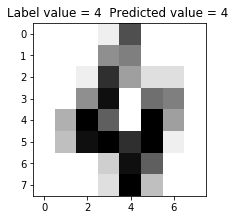

0


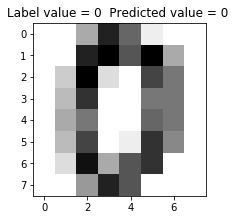

In [65]:
# Randomly select digits and test.
for index in np.random.choice(len(y_test), 2, replace = False):
    print(index)
    predicted = fitted_model.predict(X_test[index:index + 1])[0]
    label = y_test[index]
    title = "Label value = %d  Predicted value = %d " % (label, predicted)
    fig = plt.figure(1, figsize=(3,3))
    ax1 = fig.add_axes((0,0,.8,.8))
    ax1.set_title(title)
    plt.imshow(images[index], cmap = plt.cm.gray_r, interpolation = 'nearest')
    plt.show()